In [44]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

In [89]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim=10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.0
beta_start = beta
beta_end = 5.0
total_step = 500
beta_delta = (beta_end-beta_start)/total_step

save_folder = 'alpha-bidir-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

alpha_0 = 10.

mu_c_focus = 0.5

stabilizer_eps = 1.0e-16

zalpha = 10.

In [46]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [47]:
def initialize_centers():

    mu_c = mu_c_focus*torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    log_N_k = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c, log_N_k

In [48]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,log_N_k_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,log_N_k_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [49]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
log_N_k_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [50]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,log_N_k_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [51]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z,self.encode(self.decode(z))
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)

optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,log_N_k_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


In [52]:

def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z,(_,_) = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [53]:
def gauss(mus,logvars,mu_c,logvar_c,log_N_k,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())
            log_pi_k = torch.digamma(alpha_0 + log_N_k.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k.exp().sum(2,keepdim = True))

            gamma_c = ((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp())/(((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = ((((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [54]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)
    plt.show()


In [55]:
N_wide = 10
N_sigma =7
def show_generated_samples_c(mu_c,logvar_c):

    for i in range(K_model_cluster):
        sample = torch.empty(latent_dim*(N_wide+1),latent_dim).to(device)
        with torch.no_grad():
            for j in range(latent_dim):
                for k in range(N_wide+1):
                    std_c =torch.zeros(latent_dim).to(device)
                    std_c[j] = (logvar_c_g[0,j,i].exp()).sqrt()
                    sample[j*(N_wide+1)+k,:] = mu_c[0,:,i]+N_sigma*(k-N_wide/2)*std_c/N_wide
            #sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            #sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(latent_dim*(N_wide+1),1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=N_wide+1)
        #生成した６４個のデータを記録しておく

In [66]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,log_N_k_f,mus_f_p,logvars_f_p):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    KLD = -0.5*(1+logvars_f).sum() -((((-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))+torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True))).exp()).sum(2,keepdim=True)+stabilizer_eps).log()).sum() + ((log_N_k_f.exp())*(torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True)))).sum(2).squeeze() + torch.lgamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2).squeeze()) - (torch.lgamma(alpha_0 + log_N_k_f.exp())).sum(2).squeeze()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))
    ZREC = 0.5*(((2*math.pi*(logvars_f.exp()+logvars_f_p.exp())).log()+(mus_f-mus_f_p).pow(2)/(logvars_f.exp()+logvars_f_p.exp())).sum())
    return BCE+beta*KLD+zalpha*ZREC

In [57]:
def train_c(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z,(mu_p,logvar_p) = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
#              epoch,batch_idx*len(data),len(train_loader.dataset),
#                100.*batch_idx/len(train_loader),
#                inv_sm_pi_c_g
#            ))

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c_g,logvar_c_f=logvar_c_g,log_N_k_f=log_N_k_g,mus_f_p=mu_p.view(-1,latent_dim,1),logvars_f_p=logvar_p.view(-1,latent_dim,1))
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [58]:
def test_c(epoch,mu_c,logvar_c,log_N_k):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z,(mu_p,logvar_p) = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,log_N_k_f=log_N_k,mus_f_p=mu_p.view(-1,latent_dim,1),logvars_f_p=logvar_p.view(-1,latent_dim,1)).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [59]:
def train_c_epoch(epochs,mu_c,logvar_c,log_N_k):
    for epoch in range(1, epochs +1):
        train_c(epoch)
        test_c(epoch,mu_c,logvar_c,log_N_k)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [60]:
mu_c_g,logvar_c_g,log_N_k_g

(tensor([[[-0.0170,  0.0706,  0.4253,  0.0204,  0.6853, -0.5123, -0.8380,
           -1.0129, -0.3215,  0.0084],
          [ 0.3630, -0.8029,  0.0463,  0.6063,  0.3715,  0.5583,  0.1336,
           -0.1447, -0.2276, -0.4818],
          [ 0.3797,  0.0142, -0.2144,  0.9034, -0.9189,  0.6816, -1.4277,
           -0.7232,  0.4582,  0.8061],
          [ 0.6865,  0.4758,  0.5539,  0.4494,  0.0104,  0.5382,  0.0229,
            0.8631, -0.1815, -0.0303],
          [-0.4165,  0.3690, -0.1696, -0.1045, -0.1097,  0.0921, -0.3117,
           -0.4749,  0.6611, -0.1033],
          [-0.1762, -0.0457, -0.5629, -0.0071, -0.1238,  0.1807, -0.3013,
            0.3757,  0.2480, -0.7906],
          [ 0.2573, -0.5287,  0.4478, -0.0429,  0.2879,  0.2340, -0.5102,
            0.2046, -0.3180,  0.7292],
          [-0.0518, -0.3885, -0.3504,  0.5998, -0.4480, -0.7833,  0.3685,
            0.5509,  0.4868, -0.0533],
          [ 0.1722, -0.2252, -0.4874, -0.0888,  0.6775,  0.5378, -0.2876,
           -0.5139, -0

In [90]:
for i in range(20):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,log_N_k=log_N_k_g)
    scheduler.step()
    scheduler_clustering.step()

    beta += beta_delta


Train Epoch: 0 [0/60000 (0%)]	Loss: -272.290449
====> Test set loss: -2.3642
Train Epoch: 1 [0/60000 (0%)]	Loss: -241.406133
====> Test set loss: -3.6536
Train Epoch: 2 [0/60000 (0%)]	Loss: -367.754766
====> Test set loss: -4.3055
Train Epoch: 3 [0/60000 (0%)]	Loss: -436.985547
====> Test set loss: -3.5217
Train Epoch: 4 [0/60000 (0%)]	Loss: -349.737734
====> Test set loss: -3.4937
Train Epoch: 5 [0/60000 (0%)]	Loss: -348.915234
====> Test set loss: -2.7749
Train Epoch: 6 [0/60000 (0%)]	Loss: -279.133477
====> Test set loss: -0.2856
Train Epoch: 7 [0/60000 (0%)]	Loss: -6.757148
====> Test set loss: -3.4826
Train Epoch: 8 [0/60000 (0%)]	Loss: -358.630117
====> Test set loss: -3.2457
Train Epoch: 9 [0/60000 (0%)]	Loss: -328.942070
====> Test set loss: -4.5650
Train Epoch: 10 [0/60000 (0%)]	Loss: -456.226484
====> Test set loss: -5.2075
Train Epoch: 11 [0/60000 (0%)]	Loss: -561.288359
====> Test set loss: -6.0785
Train Epoch: 12 [0/60000 (0%)]	Loss: -609.894844
====> Test set loss: -6.246

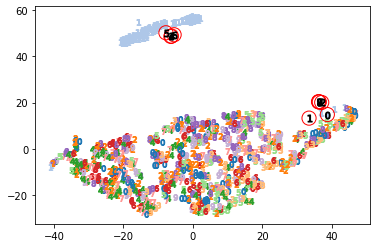

In [91]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

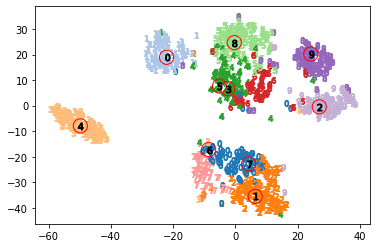

In [74]:
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

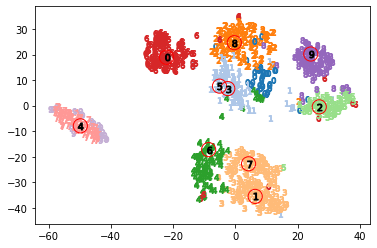

In [75]:
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

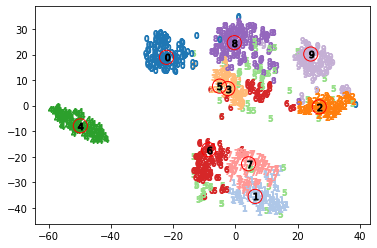

In [76]:
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [77]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [78]:
#optimizer.param_groups[0]['lr']=0.002,optimizer_clustering.param_groups[0]['lr']=0.002
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.0006276211921800001, 0.0006276211921800001, 1.1600000000000001)

In [79]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [80]:
correspond_matrix

tensor([[  0.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,  84.],
        [  0.,   0.,   0.,   0., 109.,   0.,   0.,   0.,   0.,   0.],
        [107.,   0.,   0.,   0.,   0.,   4.,   1.,   0.,   0.,   0.],
        [  4.,   0.,   0.,   4.,   0.,   2.,   3.,   0.,  97.,   0.],
        [  0.,  40.,   0.,   0.,   0.,   6.,   1.,  60.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  21.,  23.,   0.,  29.,   3.],
        [  0.,   0.,  84.,   0.,   0.,   5.,   2.,   0.,   0.,  10.],
        [  3.,   2.,   0.,   0.,   0.,  15.,  79.,   0.,   0.,   0.],
        [  1.,   0.,   0.,  73.,   0.,  13.,   4.,   0.,  10.,   2.],
        [  0.,  54.,   1.,   0.,   0.,   2.,   2.,  37.,   0.,   0.]])

In [81]:
correspond_matrix.sum()

tensor(1000.)

In [82]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([107.,  54.,  84.,  73., 109.,  21.,  79.,  60.,  97.,  84.]),
indices=tensor([2, 9, 6, 8, 1, 5, 7, 4, 3, 0]))

In [83]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.7680)

In [84]:
log_N_k_g.exp().squeeze()

tensor([10.2158,  9.0237,  8.9846,  7.3533, 10.7009,  9.7188, 11.6885,  9.1667,
        12.5008, 10.3371], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [85]:

log_N_k_g.exp().squeeze().sum()

tensor(99.6903, device='cuda:0', grad_fn=<SumBackward0>)

In [1526]:
affinity_mat = torch.zeros(K_model_cluster,K_model_cluster)
affinity_mat

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

In [1527]:
for i in range(K_model_cluster):
    for j in range(K_model_cluster):
        if i!=j:
#            affinity_mat[i,j]= 1./((mu_c_g[0,:,i]-mu_c_g[0,:,j]).pow(2).sum())
            affinity_mat[i,j]= -(0.5*(((2*math.pi*(logvar_c_g[0,:,i].exp()+logvar_c_g[0,:,j].exp())).log()+(mu_c_g[0,:,i]-mu_c_g[0,:,j]).pow(2)/(logvar_c_g[0,:,i].exp()+logvar_c_g[0,:,j].exp())).sum()))
    for j in range(K_model_cluster):
        if i==j:
            affinity_mat[i,i]= torch.min(affinity_mat)


affinity_mat

tensor([[-43.7505, -15.6462, -13.9912, -15.6614, -35.6934, -12.3036, -21.3343,
         -12.9459,  -1.2384, -43.7505, -15.3084, -15.4826, -20.3007, -17.5480,
         -13.1081],
        [-15.6462, -45.3001,  -5.5811, -13.1758, -43.4255, -10.6113, -14.6939,
          -8.2478, -15.2336, -45.3001, -17.9910, -17.5262, -12.0642,  -5.6703,
         -13.0372],
        [-13.9912,  -5.5811, -54.0844, -15.3335, -51.0547,  -7.2489, -19.2919,
          -6.8867, -13.5832, -54.0844, -14.2787, -18.4750, -16.7712,  -6.4293,
         -10.0032],
        [-15.6614, -13.1758, -15.3335, -54.0844,  -9.2338, -14.4071,  -8.8235,
         -10.5863, -15.2469,  -9.3244, -10.9926,  -3.8366,  -5.1110,  -9.5251,
          -5.7082],
        [-35.6934, -43.4255, -51.0547,  -9.2338, -54.0844, -32.9936, -13.1560,
         -17.3384, -35.6283,  -3.3664, -20.0503, -14.7899, -11.7267,  -9.5705,
         -24.2060],
        [-12.3036, -10.6113,  -7.2489, -14.4071, -32.9936, -54.0844, -21.7044,
          -5.4633, -12.0003, -3

In [1528]:
index_mat = torch.arange(K_model_cluster)
index_row = torch.arange(K_model_cluster)

In [1568]:
(i_c,j_c) = np.unravel_index(torch.argmax(affinity_mat),affinity_mat.shape)
for i in range(K_model_cluster):
    if index_row[i]==j_c:
        index_row[i]=i_c
index_mat = torch.cat((index_mat.view(-1,K_model_cluster),index_row.view(1,K_model_cluster)),0)
index_mat,i_c,j_c

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  0,  9, 10, 11, 12, 13, 14],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  0,  4, 10, 11, 12, 13, 14],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  0,  4, 10,  3, 12, 13, 14],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  0,  4, 10,  3,  3, 13, 14],
         [ 0,  1,  2,  3,  4,  5,  6,  5,  0,  4, 10,  3,  3, 13, 14],
         [ 0,  1,  1,  3,  4,  5,  6,  5,  0,  4, 10,  3,  3, 13, 14],
         [ 0,  1,  1,  3,  4,  5,  6,  5,  0,  4, 10,  3,  3,  1, 14],
         [ 0,  1,  1,  3,  4,  5,  6,  5,  0,  4, 10,  3,  3,  1,  3],
         [ 0,  1,  1,  3,  4,  5,  1,  5,  0,  4, 10,  3,  3,  1,  3],
         [ 0,  1,  1,  3,  4,  1,  1,  1,  0,  4, 10,  3,  3,  1,  3],
         [ 0,  1,  1,  1,  4,  1,  1,  1,  0,  4, 10,  1,  1,  1,  1],
         [ 0,  1,  1,  1,  1,  1,  1,  1,  0,  1, 10,  1,  1,  1,  1],
         [ 0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1],
      

In [1569]:
affinity_mat[i_c,:]= torch.max(affinity_mat[i_c],affinity_mat[j_c])
#affinity_mat[i_c,:]= (0.5*(affinity_mat[i_c].exp()+affinity_mat[j_c].exp())).log()
affinity_mat[j_c,:]= torch.min(affinity_mat)
affinity_mat[:,j_c]= torch.min(affinity_mat)
affinity_mat[i_c,i_c]= torch.min(affinity_mat)
affinity_mat[:,i_c]= affinity_mat[i_c,:]
affinity_mat

tensor([[-54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844],
        [-54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844],
        [-54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844],
        [-54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844],
        [-54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844],
        [-54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844, -54.0844,
         -54.0844, -54.0844, -5

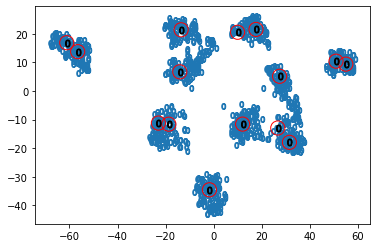

In [1570]:
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
drawpoints_with_centers(data_points,index_row[torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy()],center_points,index_row)
